<h1>Fast.ai's Machine Learning Course - Lesson 3<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-Forest-from-scratch!" data-toc-modified-id="Random-Forest-from-scratch!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Forest from scratch!</a></span><ul class="toc-item"><li><span><a href="#Load-in-our-data-from-last-lesson" data-toc-modified-id="Load-in-our-data-from-last-lesson-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load in our data from last lesson</a></span></li><li><span><a href="#Basic-data-structures" data-toc-modified-id="Basic-data-structures-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Basic data structures</a></span></li><li><span><a href="#Single-branch" data-toc-modified-id="Single-branch-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Single branch</a></span><ul class="toc-item"><li><span><a href="#Find-best-split-given-variable" data-toc-modified-id="Find-best-split-given-variable-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Find best split given variable</a></span></li><li><span><a href="#Speeding-things-up" data-toc-modified-id="Speeding-things-up-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Speeding things up</a></span></li></ul></li><li><span><a href="#Full-single-tree" data-toc-modified-id="Full-single-tree-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Full single tree</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Predictions</a></span></li></ul></li><li><span><a href="#Putting-it-together" data-toc-modified-id="Putting-it-together-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Putting it together</a></span></li></ul></div>

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

> This is my revised and extended version of the first notebook from the [Fast.ai ML course (2018)](http://course18.fast.ai/ml). It covers lessons 5 and 6.

# Random Forest from scratch!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

## Load in our data from last lesson

In [3]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [4]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

To simplify things we'll start with only two columns:

In [5]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

## Basic data structures

Top-down approach; assuming everything we need already exist :)

In [6]:
class TreeEnsemble():
    '''
    RF implementation. With sampling only, no replacement (no bootstrapping)
    '''
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # Create a list of permuted numbers from 0 to len(y)-1 and get the first sample_sz ones
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz] # or use choice()
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [7]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf

In [8]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [9]:
m.trees[0]

In [10]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: 
            idxs=np.arange(len(y)) # the root contains all indexes
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1] # rows and columns 
        self.val = np.mean(y[idxs]) # value at the root of the tree
        self.score = float('inf') # best score to start xD
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        # Use all features (max_features not implemented)
        for i in range(self.c):
            self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    #@property means: you don't have to type () to invoke this
    @property
    def split_name(self): 
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): 
        return self.score == float('inf') # inf because leaves don't split
    
    def __repr__(self):
        '''
        This is what typing the decision tree name will print
        '''
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [11]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [12]:
m.trees[0]

n: 1000; val:10.05890091842597

In [13]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 

## Single branch

### Find best split given variable

First we have to find what samples are we using, in order to pass those to sklearn's RF, which is the one we are comparing against ours.

In [14]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [15]:
tree

n: 1000; val:10.05890091842597

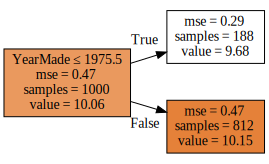

In [16]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False) # single branch
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [17]:
def find_better_split(self, var_idx):
    
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    # for every index in n
    for i in range(self.n):
        lhs = x<=x[i] # left branch if we split in the value for index i
        rhs = x>x[i] # right branch
        
        # not every split is valid or useful!
        if rhs.sum()<self.min_leaf or lhs.sum()<self.min_leaf: 
            continue
            
        lhs_std = y[lhs].std() # std dev
        rhs_std = y[rhs].std()
        
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

In [18]:
%timeit find_better_split(tree, 1) # feature 1
tree

75.7 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.05890091842597score:683.6525731860123; split:4300.0; var:MachineHoursCurrentMeter

In [19]:
find_better_split(tree, 0) # feature 0
tree

n: 1000; val:10.05890091842597score:661.5320798071433; split:1975.0; var:YearMade

YearMade achieves the best split, like in Scikit-Learn

### Speeding things up

The computational complexity we have is N^2, so we'll try to make it better... calculating the std dev in a less complex way, having in mind that in each iteration, the subsets only vary in one sample (so we'll sum in one what we have to subtract in the other):

In [20]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [21]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x) # sorting is the key
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    
    # keep track of the count, the sum, and the sum of squared, for left and right subsets
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum() # Start with everything in the right
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        
        # skip repeated values
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [22]:
%timeit find_better_split(tree,1)
tree

2.5 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 1000; val:10.05890091842597score:683.6525731856678; split:4300.0; var:MachineHoursCurrentMeter

In [23]:
find_better_split(tree,0); tree

n: 1000; val:10.05890091842597score:661.5320798069813; split:1975.0; var:YearMade

Time was improved a lot! (if not, use %prun always to improve it), and the results are the same. We'll include this function in our class:

In [24]:
DecisionTree.find_better_split = find_better_split

In [25]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.05890091842597score:661.5320798069813; split:1975.0; var:YearMade

## Full single tree

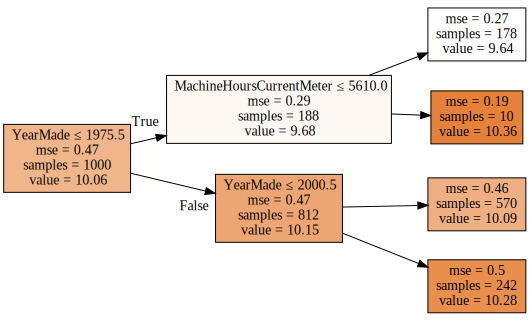

In [26]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

Let's make find_varsplit "recursive"!

In [27]:
def find_varsplit(self):
    
    for i in range(self.c): 
        self.find_better_split(i)
        
    if self.is_leaf: 
        return
    
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [28]:
DecisionTree.find_varsplit = find_varsplit

In [29]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.05890091842597score:661.5320798069813; split:1975.0; var:YearMade

In [30]:
tree.lhs

n: 188; val:9.678629055342135score:97.40501770435533; split:4300.0; var:MachineHoursCurrentMeter

In [31]:
tree.rhs

n: 812; val:10.14694415766213score:555.1375349693434; split:1987.0; var:YearMade

In [32]:
tree.lhs.lhs

n: 178; val:9.640571944923483score:90.73840720355781; split:1967.0; var:YearMade

In [33]:
tree.lhs.rhs

n: 10; val:10.35604562079414score:3.3916942580414804; split:12543.0; var:MachineHoursCurrentMeter

## Predictions

Now we need something to make predictions :)

We'll get more columns this time:

In [34]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [35]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

Wall time: 432 ms


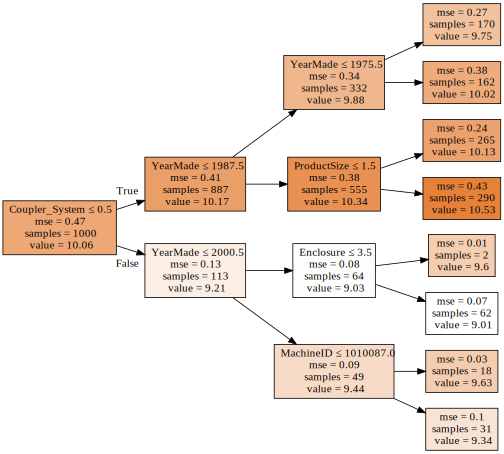

In [36]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

In [37]:
def predict(self, x): 
    return np.array([self.predict_row(xi) for xi in x]) # as x is a matrix, xi is the row (first dimension)

DecisionTree.predict = predict

In [38]:
def predict_row(self, xi):
    if self.is_leaf: 
        return self.val
    
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    
    return t.predict_row(xi) # recursive

DecisionTree.predict_row = predict_row

In [39]:
%time preds = tree.predict(X_valid[cols].values)

Wall time: 95 ms


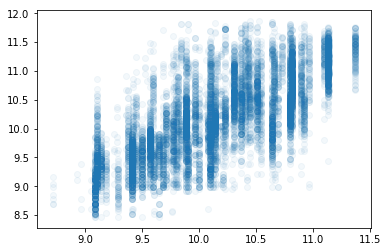

In [40]:
plt.scatter(preds, y_valid, alpha=0.05); # set alpha when you have a lot of points!

In [41]:
metrics.r2_score(preds, y_valid)

0.3377708370401098

Wall time: 4 ms


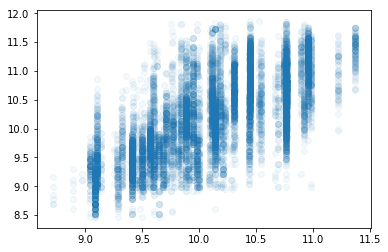

In [42]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05);

In [43]:
metrics.r2_score(preds, y_valid)

0.14516117116771465

Wow! our decision tree is much better! (:

# Putting it together

In [44]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [45]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [46]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000) # 5 trees

In [47]:
preds = ens.predict(X_valid[cols].values)

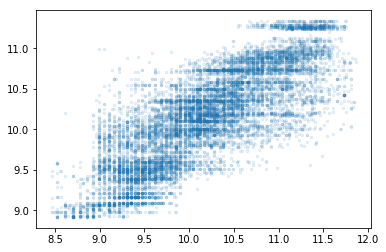

In [48]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [49]:
metrics.r2_score(y_valid, preds)

0.6384786236777693

Wall time: 7.51 s


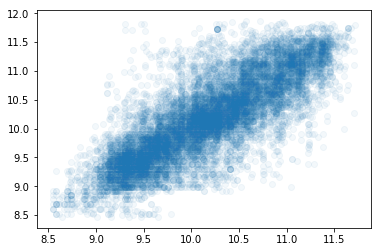

In [50]:
m = RandomForestRegressor(n_estimators=5, min_samples_leaf=5, bootstrap=False)
%time m.fit(X_train[cols], y_train)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05);

In [51]:
metrics.r2_score(y_valid, preds)

0.629144671225208

So that's good! our Random Forest is even better than the original :) But also much slower. The implementation of Scikit-Learn is almost entirely written in **Cython**; designed to give C-like performance to Python code (in fact, it compiles the code to C)

Cython is something we want to know (most people don't know it) and to use when time is critical.

In [52]:
%load_ext Cython

Let's try a simple function:

In [53]:
def fib1(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

Its correspondence in Cython is the same, only adding the first line. The result is that we achieve a function 2 times quicker, only because of the compilation.

Note: this won't work if you don't have Cython installed, and a C compiler (Windows users read [this](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows))

In [54]:
%%cython
def fib2(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

Here is the function written in Cython, using the proper types:

In [55]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = t + b

In [56]:
%timeit fib1(50)

576 ns ± 7.99 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [57]:
%timeit fib2(50)

302 ns ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [58]:
%timeit fib3(50)

48.7 ns ± 1.59 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
